# Detectron2 for Computer Vision Image Recognition

**Benedict Aryo**

We will try to utilize latest package by Facebook AI Research [FAIR](https://ai.facebook.com/) from the creator of Mask-RCNN https://arxiv.org/abs/1703.06870 which aim to be the next-generation platform for object detection and segmentation.

<br>

___

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="300">

Detectron2 is Facebook AI Research's next generation software system
that implements state-of-the-art object detection algorithms.
It is a ground-up rewrite of the previous version,
[Detectron](https://github.com/facebookresearch/Detectron/),
and it originates from [maskrcnn-benchmark](https://github.com/facebookresearch/maskrcnn-benchmark/). Detectron2 can be downloaded in: https://github.com/facebookresearch/detectron2

<div align="center">
  <img src="https://user-images.githubusercontent.com/1381301/66535560-d3422200-eace-11e9-9123-5535d469db19.png"/>
</div>

---
## Detectron2 Benchmark
Detectron2 having fastest training time compared with some other popular open source Mask R-CNN implementations. <br>
**Here's the bechmarck:**

<img src="https://github.com/BenedictusAryo/Mask-RCNN_Detectron2/raw/master/assets/detectron2_result.png" width="400">

___
## Detectron2 Model Zoo
provide a large set of baseline results and trained models available for download in the [Detectron2 Model Zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md).

Detectron2 Pretrained model architecture can be used to:
* Object Detection
* Instance Segmentation
* Panoptic Segmentation
* Person Keypoint Detection
* Semantic Segmentation (soon)

___

# Inference using Detectron2
We will try using Detectron2 pretrained model to test it's prediction output while learning about it's functionality.

See `detectron2` Documentation at: https://detectron2.readthedocs.io/

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Load Images to predict
We need to prepare the sample input image to run prediction. In this case we will use sample image from [Ms. COCO Dataset](https://cocodataset.org/#home)

In [2]:
# download sample image using wget
!wget http://images.cocodataset.org/val2017/000000439715.jpg -O input.jpg

--2020-07-06 15:53:50--  http://images.cocodataset.org/val2017/000000439715.jpg
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.100.3
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.100.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209222 (204K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>] 204.32K   139KB/s    in 1.5s    

2020-07-06 15:53:52 (139 KB/s) - ‘input.jpg’ saved [209222/209222]



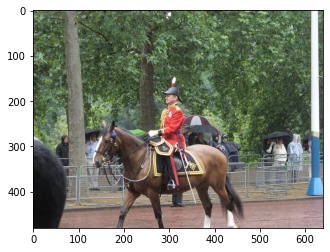

In [4]:
# Load BGR test-image using opencv
img = cv2.imread("./input.jpg")

# Show the RGB image using matplotlib imshow
plt.imshow(img[...,::-1]);

## Mask R-CNN Instance Segmentation inference
